# Model Notebook

This notebook is only used to help speed up data cleaning/transformations and model creation process.

In [39]:
import math
import time
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from matplotlib.animation import FuncAnimation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay

np.set_printoptions(suppress=True)

field_height = 53.3
field_length = 120
endzone_length = 10
seconds_in_a_half = 15 * 60
seconds_in_overtime = 10 * 60

In [2]:
start = time.time()
games = pd.read_csv('data/games.csv')
print("Done in:", time.time() - start)

Done in: 0.00728607177734375


In [3]:
start = time.time()
players = pd.read_csv('data/players.csv')
print("Done in:", time.time() - start)

Done in: 0.00904393196105957


In [4]:
start = time.time()
plays = pd.read_csv('data/plays.csv')
print("Done in:", time.time() - start)

Done in: 0.08388209342956543


In [5]:
start = time.time()
plays = plays.merge(games, on='gameId')
print("Done in:", time.time() - start)

plays['is_home_offense'] = plays['possessionTeam'] == plays['homeTeamAbbr']
print("Done in:", time.time() - start)

Done in: 0.029972314834594727
Done in: 0.03299713134765625


In [6]:
start = time.time()
scout = pd.read_csv('data/PFFScoutingData.csv')
print("Done in:", time.time() - start)

Done in: 0.04850912094116211


In [7]:
start = time.time()
tracking_2018 = pd.read_csv('data/tracking2018.csv')
tracking_2019 = pd.read_csv('data/tracking2019.csv')
tracking_2020 = pd.read_csv('data/tracking2020.csv')
tracking = tracking_2018.append([tracking_2019, tracking_2020])
print("Done in:", time.time() - start)

Done in: 72.2629029750824


In [8]:
start = time.time()
left_mask = tracking['playDirection'] == 'left'
right_mask = tracking['playDirection'] == 'right'
tracking.loc[left_mask, 'stdX'] = field_length - tracking.loc[left_mask, 'x']
tracking.loc[left_mask, 'stdY'] = field_height - tracking.loc[left_mask, 'y']
tracking.loc[left_mask, 'stdDir'] = (360 - tracking.loc[left_mask, 'dir']) % 360
tracking.loc[right_mask, 'stdX'] = tracking.loc[right_mask, 'x']
tracking.loc[right_mask, 'stdY'] = tracking.loc[right_mask, 'y']
tracking.loc[right_mask, 'stdDir'] = tracking.loc[right_mask, 'dir']
tracking['stdR'] = (tracking['stdX'].pow(2) + tracking['stdY'].pow(2)).pow(1/2)
tracking['stdTheta'] = np.arctan(tracking['stdY']/tracking['stdX'])
tracking['nflId'] = tracking['nflId'].fillna(-1)
print("Done in:", time.time() - start)

Done in: 20.47235083580017


In [9]:
num_games = plays['gameId'].unique().size

start = time.time()
play_results = plays.groupby(['specialTeamsPlayType', 'specialTeamsResult']).size().unstack('specialTeamsPlayType')
play_results = play_results.divide(num_games)
play_results_probs = play_results.div(play_results.sum(axis=0), axis=1)
excitement_scores = play_results_probs.subtract(1).multiply(-1).unstack().dropna().rename('excitement_score_v1')
plays = plays.join(excitement_scores, on=['specialTeamsPlayType', 'specialTeamsResult'])
print("Done in:", time.time() - start)

start = time.time()
plays.loc[plays['is_home_offense'], 'score_diff'] = plays['preSnapHomeScore'] - plays['preSnapVisitorScore']
plays.loc[~plays['is_home_offense'], 'score_diff'] = plays['preSnapVisitorScore'] - plays['preSnapHomeScore']
plays['score_diff_ex'] = pd.cut(plays['score_diff'].abs(), 
    bins=[-1, 0, 1, 3, 5, 8, 11, 16, 21, 26, 31], 
    labels=[.9, 1, .8, .7, .6, .5, .4, .3, .2, .1]
).astype(float)
plays['excitement_score_v2'] = 0.5 * plays['excitement_score_v1'] + 0.5 * plays['score_diff_ex']
print("Done in:", time.time() - start)

start = time.time()
plays['gameClockMins'] = plays['gameClock'].str.split(':').str[0]
plays['gameClockSecs'] = plays['gameClock'].str.split(':').str[1]
plays['seconds_left_in_quarter'] = plays['gameClockMins'].astype(int) * 60 + plays['gameClockSecs'].astype(int)
plays.loc[plays['quarter'].isin([2, 4, 5]), 'seconds_left_in_half'] = plays['seconds_left_in_quarter']
plays.loc[plays['quarter'].isin([1, 3]), 'seconds_left_in_half'] = plays['seconds_left_in_quarter'] + seconds_in_a_half
print("Done in:", time.time() - start)

start = time.time()
plays.loc[plays['quarter'] != 5, 'time_left_ex'] = (1 - plays['seconds_left_in_half'] / (seconds_in_a_half * 2))
plays.loc[plays['quarter'] == 5, 'time_left_ex'] = (1 - plays['seconds_left_in_half'] / seconds_in_overtime)
plays['quarter_ex'] = plays['quarter'] / 5
plays['excitement_score_v3'] = 0.25 * (plays['excitement_score_v1'] + plays['score_diff_ex'] + plays['quarter_ex'] + plays['time_left_ex'])
print("Done in:", time.time() - start)

Done in: 0.08854794502258301
Done in: 0.022433996200561523
Done in: 0.43680787086486816
Done in: 0.00873112678527832


In [10]:
kickoffs = plays[plays['specialTeamsPlayType']=='Kickoff'].reset_index(drop=True)

start = time.time()
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
transformed = encoder.fit_transform(kickoffs[['specialTeamsResult']])
output_cols = [x.split('_')[1] for x in encoder.get_feature_names()]
ohe_df = pd.DataFrame(transformed, columns=output_cols)
kickoffs = pd.concat([kickoffs, ohe_df], axis=1)
print("Done in:", time.time() - start)

start = time.time()
kickoffs['initial_excitement'] = 1/3 * (kickoffs['score_diff_ex'] + kickoffs['quarter_ex'] + kickoffs['time_left_ex'])
kickoff_tracking = kickoffs.merge(tracking, on=['gameId', 'playId'])
print("Done in:", time.time() - start)

start = time.time()
kickoff_tracking['is_off'] = (kickoff_tracking['is_home_offense'] & (kickoff_tracking['team'] == 'home')) | (~kickoff_tracking['is_home_offense'] & (kickoff_tracking['team'] == 'away')) | (kickoff_tracking['team'] == 'football')
print("Done in:", time.time() - start)

Done in: 0.011757850646972656
Done in: 124.90791392326355
Done in: 2.0877270698547363


In [11]:
# kickoff_tracking = kickoff_tracking[(kickoff_tracking['gameId']==2018090600) & (kickoff_tracking['playId'].isin([37, 677]))]
# kickoff_tracking.head()

In [12]:
kickoff_tracking.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,position,team,frameId,playDirection,stdX,stdY,stdDir,stdR,stdTheta,is_off
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,FS,home,1,right,43.76,8.10,53.28,44.503344,0.183029,True
1,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,FS,home,2,right,43.77,8.10,73.05,44.513177,0.182988,True
2,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,FS,home,3,right,43.78,8.10,70.39,44.523010,0.182947,True
3,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,FS,home,4,right,43.80,8.11,71.53,44.544496,0.183086,True
4,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,FS,home,5,right,43.84,8.12,75.17,44.585648,0.183143,True


The only features we're interested in right now is location of players and the ball. So we'll selected those columns and standardize (scale) them.

In [13]:
features = ['stdR', 'stdTheta']

sc = MinMaxScaler()

start = time.time()
kickoff_tracking[features] = sc.fit_transform(kickoff_tracking[features])
print("Done in:", time.time() - start)

Done in: 31.64619517326355


In [14]:
start = time.time()
sort_cols = ['gameId', 'playId', 'frameId', 'is_off', 'nflId']
df = kickoff_tracking[[*sort_cols, *features]].set_index(sort_cols).sort_index(level=sort_cols).droplevel('nflId')
df = df.set_index(df.groupby(['gameId', 'playId', 'frameId']).cumcount().rename('playerNum'), append=True)
df = df[features].unstack(['is_off', 'playerNum']).reset_index(['gameId', 'playId', 'frameId'])
print("Done in:", time.time() - start)

df.head()

Done in: 23.00712490081787


gameId playId frameId      stdR                                \
is_off                                   False                                 
playerNum                                    0         1         2         3   
0          2018090600     37       1  0.553096  0.522896  0.480649  0.660584   
1          2018090600     37       2  0.553035  0.522996  0.480588  0.660573   
2          2018090600     37       3  0.553071  0.523095  0.480588  0.660503   
3          2018090600     37       4  0.553071  0.523151  0.480611  0.660573   
4          2018090600     37       5  0.553071  0.523306  0.480671  0.660584   

                                         ...  stdTheta                      \
is_off                                   ...      True                       
playerNum         4         5         6  ...        13        14        15   
0          0.683967  0.480869  0.439862  ...  0.329865  0.680000  0.468614   
1          0.683939  0.480799  0.439796  ...  0.329646  0.680000  0.468796   
2          0.683939  0.480812  0.439769  ...  0.329533  0.679953  0.468796   
3          0.683910  0.480812  0.439769  ...  0.329524  0.679900  0.468886   
4          0.683910  0.480743  0.439769  ...  0.329515  0.679900  0.469105   

                                                                       \
is_off                                                                  
playerNum        16        17        18        19        20        21   
0          0.611685  0.508762  0.586472  0.583543  0.426882  0.631340   
1          0.611403  0.508847  0.583207  0.583510  0.426980  0.631282   
2          0.611184  0.508931  0.579726  0.583340  0.427077  0.631229   
3          0.611194  0.509016  0.576015  0.583290  0.427145  0.631176   
4          0.611268  0.509100  0.572099  0.583000  0.427378  0.631069   

                     
is_off               
playerNum        22  
0          0.658324  
1          0.658429  
2          0.658587  
3          0.658798  
4          0.658956  

[5 rows x 49 columns]

In [45]:
results = kickoff_tracking.groupby(['gameId', 'playId', 'frameId'])[output_cols].first()
results.head()

Downed  Fair Catch  Kickoff Team Recovery  Muffed  \
gameId     playId frameId                                                      
2018090600 37     1           0.0         0.0                    0.0     0.0   
                  2           0.0         0.0                    0.0     0.0   
                  3           0.0         0.0                    0.0     0.0   
                  4           0.0         0.0                    0.0     0.0   
                  5           0.0         0.0                    0.0     0.0   

                           Out of Bounds  Return  Touchback  
gameId     playId frameId                                    
2018090600 37     1                  0.0     0.0        1.0  
                  2                  0.0     0.0        1.0  
                  3                  0.0     0.0        1.0  
                  4                  0.0     0.0        1.0  
                  5                  0.0     0.0        1.0

In [46]:
df = df.join(results, on=['gameId', 'playId', 'frameId'])
df.head()

,"(gameId, , )","(playId, , )","(frameId, , )","(stdR, False, 0)","(stdR, False, 1)","(stdR, False, 2)","(stdR, False, 3)","(stdR, False, 4)","(stdR, False, 5)","(stdR, False, 6)",...,"(stdTheta, True, 20)","(stdTheta, True, 21)","(stdTheta, True, 22)",Downed,Fair Catch,Kickoff Team Recovery,Muffed,Out of Bounds,Return,Touchback
0,2018090600,37,1,0.553096,0.522896,0.480649,0.660584,0.683967,0.480869,0.439862,...,0.426882,0.631340,0.658324,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2018090600,37,2,0.553035,0.522996,0.480588,0.660573,0.683939,0.480799,0.439796,...,0.426980,0.631282,0.658429,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2018090600,37,3,0.553071,0.523095,0.480588,0.660503,0.683939,0.480812,0.439769,...,0.427077,0.631229,0.658587,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2018090600,37,4,0.553071,0.523151,0.480611,0.660573,0.683910,0.480812,0.439769,...,0.427145,0.631176,0.658798,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2018090600,37,5,0.553071,0.523306,0.480671,0.660584,0.683910,0.480743,0.439769,...,0.427378,0.631069,0.658956,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Then we'll convert the DataFrame to a 2D array.

In [48]:
values = df.values
print(values.shape)
print(values[0])

(618098, 56)
[2.01809060e+09 3.70000000e+01 1.00000000e+00 5.53095559e-01
 5.22896344e-01 4.80648535e-01 6.60584415e-01 6.83967252e-01
 4.80868708e-01 4.39861895e-01 5.16338284e-01 7.95061811e-01
 4.08953143e-01 4.21182966e-01 3.56200050e-01 2.99571912e-01
 2.96243873e-01 4.48049165e-01 3.19173744e-01 3.86027982e-01
 3.30171198e-01 3.44803820e-01 3.67992180e-01 3.05836510e-01
 3.99778786e-01 4.26450259e-01 5.37624925e-01 6.02738911e-01
 5.48160466e-01 3.67949691e-01 4.81729350e-01 3.75553518e-01
 4.70716375e-01 4.74209721e-01 4.00768151e-01 3.56011607e-01
 4.11065449e-01 5.38590477e-01 3.74742907e-01 3.29865065e-01
 6.79999898e-01 4.68614001e-01 6.11685385e-01 5.08762379e-01
 5.86472143e-01 5.83542745e-01 4.26881952e-01 6.31340218e-01
 6.58323573e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]


Input is only 46 values, the first 3 values in x in order are: `gameId`, `playId`, `frameId`. The last 7 columns are the encoded `playResult` values. We'll drop the first 3 columns for now, but potentially may want them later if we need them for an RNN.

In [49]:
x = np.array([x[3:-7] for x in values])
print(x.shape)
print(x[0])

(618098, 46)
[0.55309556 0.52289634 0.48064853 0.66058442 0.68396725 0.48086871
 0.43986189 0.51633828 0.79506181 0.40895314 0.42118297 0.35620005
 0.29957191 0.29624387 0.44804917 0.31917374 0.38602798 0.3301712
 0.34480382 0.36799218 0.30583651 0.39977879 0.42645026 0.53762492
 0.60273891 0.54816047 0.36794969 0.48172935 0.37555352 0.47071637
 0.47420972 0.40076815 0.35601161 0.41106545 0.53859048 0.37474291
 0.32986506 0.6799999  0.468614   0.61168538 0.50876238 0.58647214
 0.58354274 0.42688195 0.63134022 0.65832357]


Now we need to get the output values, which will be an array of encoded values representing the result of each play. This is just the last 7 columns of `values`. 

In [50]:
y = np.array([x[-7:] for x in values])
print(y.shape)
print(y[0])

(618098, 7)
[0. 0. 0. 0. 0. 0. 1.]


In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

In [19]:
num_input_nodes = x.shape[1]
num_hidden_nodes = x.shape[1] * 2
num_output_nodes = y.shape[1]

model = Sequential()
model.add(Dense(num_hidden_nodes, input_dim=num_input_nodes, activation='relu'))
model.add(Dense(num_output_nodes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=3, verbose=1)

2021-10-19 20:00:39.875194: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-19 20:00:40.086051: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Epoch 1/3
12942/12942 [==============================] - 11s 848us/step - loss: 0.5834 - accuracy: 0.7240
Epoch 2/3
12942/12942 [==============================] - 11s 838us/step - loss: 0.5018 - accuracy: 0.7775
Epoch 3/3
12942/12942 [==============================] - 11s 824us/step - loss: 0.4718 - accuracy: 0.7958


In [20]:
results = model.evaluate(x_test, y_test)
print(f'Loss: {results[0]}; Accuracy: {results[1]}')

6375/6375 [==============================] - 4s 618us/step - loss: 0.4698 - accuracy: 0.7968
Loss: 0.46976152062416077; Accuracy: 0.7968162298202515


In [40]:
y_pred = model.predict(x_test)
for pred, actual in zip(y_pred[:10], y_test[:10]):
	print(f'Pred: {pred}; Actual: {actual}')

Pred: [0.00036127 0.00231977 0.00165288 0.02097034 0.01693178 0.50095797
 0.45680606]; Actual: [0. 0. 0. 0. 0. 1. 0.]
Pred: [0.00001141 0.00011926 0.00021751 0.009123   0.00038122 0.9898117
 0.00033581]; Actual: [0. 0. 0. 0. 0. 1. 0.]
Pred: [0.00000063 0.00002131 0.00003431 0.01331237 0.00051692 0.9828774
 0.003237  ]; Actual: [0. 0. 0. 0. 0. 1. 0.]
Pred: [0.00000138 0.00008529 0.00005906 0.02441989 0.00328192 0.94127005
 0.03088234]; Actual: [0. 0. 0. 1. 0. 0. 0.]
Pred: [0.00013848 0.0010171  0.00106278 0.01086832 0.00110445 0.9855552
 0.0002536 ]; Actual: [0. 0. 0. 0. 0. 1. 0.]
Pred: [0.00026136 0.00127093 0.00133621 0.00582989 0.00058473 0.99062705
 0.0000899 ]; Actual: [0. 0. 0. 0. 0. 1. 0.]
Pred: [0.00004319 0.00018301 0.00008739 0.00773686 0.00252671 0.41850626
 0.5709166 ]; Actual: [0. 0. 0. 0. 0. 1. 0.]
Pred: [0.00002514 0.00020575 0.00007697 0.00976927 0.00577794 0.5189752
 0.4651697 ]; Actual: [0. 0. 0. 0. 0. 0. 1.]
Pred: [0.00031195 0.00248378 0.00164183 0.01000823 0.0019126

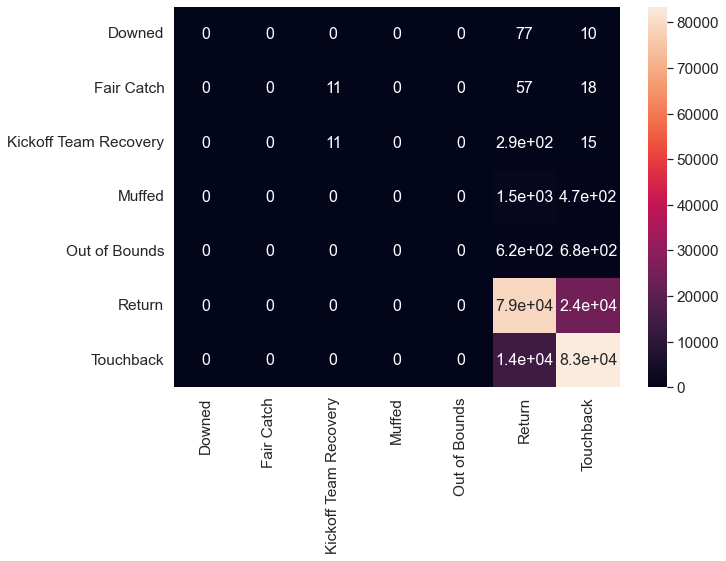

In [41]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
df_cm = pd.DataFrame(matrix, output_cols, output_cols)

plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})

plt.show()